In [51]:
# CUPY_GPU_MEMORY_LIMIT="70%"

In [52]:
# IMPORTS
%load_ext autoreload
%autoreload 2
%matplotlib inline



import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
################################# FOR GPU ###############################
# import cusignal
import segyio
# from scipy.signal import convolve, filtfilt
############################### OPTIMIZATION ############################
from pylops.utils                      import dottest
from pylops.utils.backend              import get_lstsq
from pylops.utils.wavelets             import *
from pylops.basicoperators             import *
from pylops.avo.avo                    import *
from pylops.avo.poststack              import *
from pylops.avo.prestack               import *
from pylops.optimization.basic         import *
from pylops.optimization.leastsquares  import *


#########################################################################
import cupy as cp
cp.cuda.Device(device=0).use()
########################################################################
dtype = np.float32



# import warnings
# warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# LOADING. EDA

## Load original data (3D)

In [53]:
def grid_view(segyfile):

    # Extract header word for all traces
    sourceX = segyfile.attributes(segyio.TraceField.SourceX)[:]

    # Scatter plot sources and receivers color-coded on their number
    plt.figure()
    sourceY = segyfile.attributes(segyio.TraceField.SourceY)[:]
    nsum = segyfile.attributes(segyio.TraceField.NSummedTraces)[:]
    plt.scatter(sourceX, sourceY, c=nsum, edgecolor='none')

    groupX = segyfile.attributes(segyio.TraceField.GroupX)[:]
    groupY = segyfile.attributes(segyio.TraceField.GroupY)[:]
    nstack = segyfile.attributes(segyio.TraceField.NStackedTraces)[:]
    plt.scatter(groupX, groupY, c=nstack, edgecolor='none')

Let's now read the data. 

Note that we add the `ignore_geometry=True` parameter when we open the file. As we will see the geometry in this file is not regular, so we cannot rely on the inner working of segyio to get our data into a 3d numpy array as it was the case for the Kerry3D data.

In [54]:
orig_file = '''.\SEISMIC\94p07ful.sgy'''

f = segyio.open(orig_file, ignore_geometry=True)
f.mmap()

False

In [55]:
# grid_view(f)

From grid above we see that the geometry metadata of our file is erroneous thus we will reorganize them into a regular grid. We use numpy for that.

In [56]:
# Geometry fix - time consuming

t = f.samples
il = f.attributes(segyio.TraceField.INLINE_3D)[:]
xl = f.attributes(segyio.TraceField.CROSSLINE_3D)[:]

traces = segyio.collect(f.trace)[:] # DATA
ntraces, nt = traces.shape # N traces and N time

# Regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

# regular axis
ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))
print('# missing traces: {}'.format(np.sum(~traces_available)))

# reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

# missing traces: 0


In [57]:
print(f"traces shape {traces.shape}")
print(f"d shape {d.shape}")

print(t.min(),t.max())

traces shape (116532, 1001)
d shape (249, 468, 1001)
0.0 2000.0


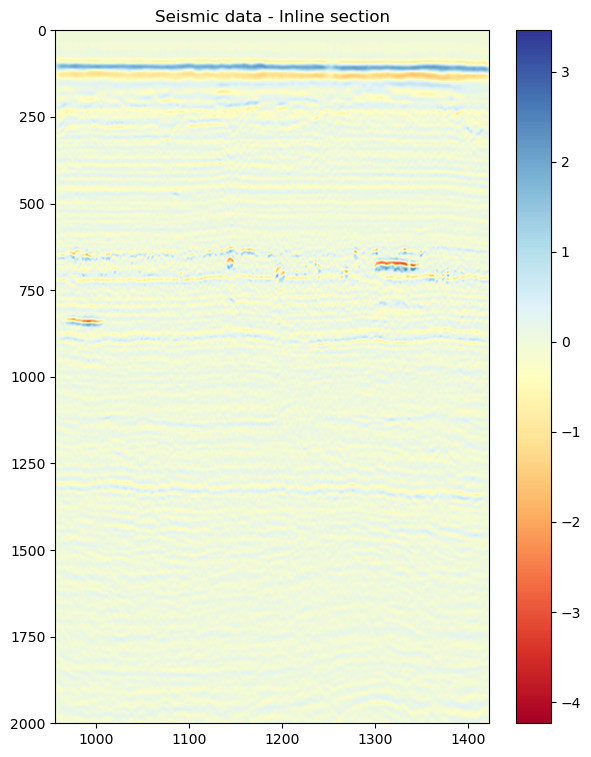

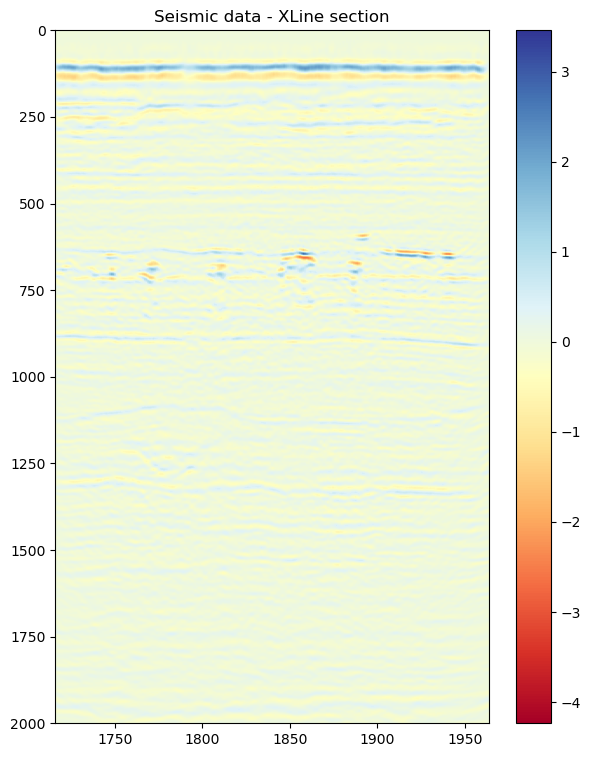

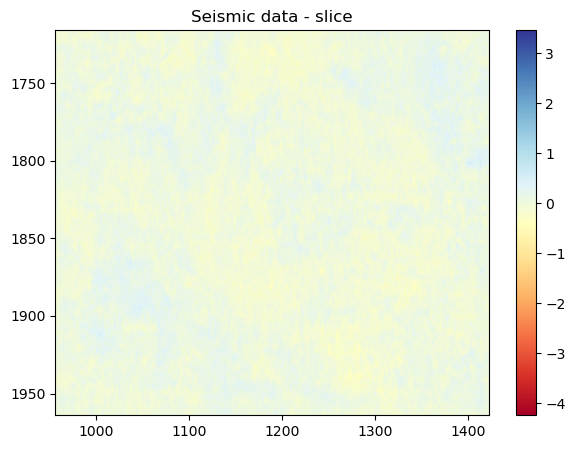

In [58]:
plt.figure(figsize=(7, 9))
plt.imshow(d[nil//2].T, cmap='RdYlBu', vmin=traces.min(), vmax=traces.max(),
           extent=(xlines[0], xlines[-1], t[-1], t[0]))
plt.title('Seismic data - Inline section')
plt.colorbar()
plt.axis('tight');
plt.figure(figsize=(7, 9))
plt.imshow(d[:,nxl//2].T, cmap='RdYlBu', vmin=traces.min(), vmax=traces.max(),
           extent=(ilines[0], ilines[-1], t[-1], t[0]))
plt.title('Seismic data - XLine section')
plt.colorbar()
plt.axis('tight');
plt.figure(figsize=(7, 5))
plt.imshow(d[..., nt//2], cmap='RdYlBu', vmin=traces.min(), vmax=traces.max(),
           extent=(xlines[0], xlines[-1], ilines[-1], ilines[0]))
plt.title('Seismic data - slice')
plt.colorbar()
plt.axis('tight');

### Animated time slices:

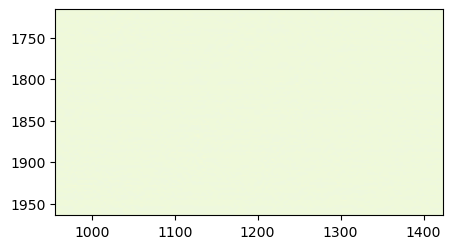

In [59]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
fig.set_size_inches(5,7)
nts = np.arange(t[0]//2,t[-1]//2,10,dtype=int)
def animate(i):
    # ax.clear()
    nt = nts[i]
    return ax.imshow(d[..., nt], cmap='RdYlBu', vmin=traces.min(), vmax=traces.max(),
            extent=(xlines[0], xlines[-1], ilines[-1], ilines[0]))
    # ax.title(f'Seismic data - slice {nt}')
    # ax.colorbar()
    # ax.axis('tight');
ani = FuncAnimation(fig, animate, frames=len(nts),interval=100, repeat=False)

In [60]:
# Animation - time consuming
from IPython.display import HTML
HTML(ani.to_html5_video())

### Estimate the wavelet and apply relative inversion

In [61]:
# NOT NEEDED!

# nt_wav = 41 # len of wavelet in samples
# nfft = 2**11 # len of fft

# # time axis for wavelet
# t_wav = np.arange(nt_wav) * (dt/1000) 
# t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

# # estimate wavelet spectrum
# wav_est_fft = np.mean(np.abs(np.fft.fft(d[..., 500:], nfft, axis=-1)), axis=(0, 1))
# fwest = np.fft.fftfreq(nfft, d=dt/1000)

# # create wavelet in time
# wav_est = np.real(np.fft.ifft(wav_est_fft)[:nt_wav])
# wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
# wav_est = wav_est / wav_est.max()
# wcenter = np.argmax(np.abs(wav_est))

# # display wavelet
# fig, axs = plt.subplots(1, 2, figsize=(20, 5))
# fig.suptitle('Statistical wavelet estimate')
# axs[0].plot(fwest[:nfft//2], wav_est_fft[:nfft//2], 'k')
# axs[0].set_title('Frequency')
# axs[1].plot(t_wav, wav_est, 'k')
# axs[1].set_title('Time');

### Cut the data:

In [62]:
# swap time axis to first dimension

# For d_small = d_original:
# itmin, itmax = t.min(),t.max()

itmin, itmax = 250,601

d_small = d[..., itmin:itmax]

# d_small = np.swapaxes(d_small, -1, 0)

In [63]:
# See time limits:
t[itmin],t[itmax]

(500.0, 1202.0)

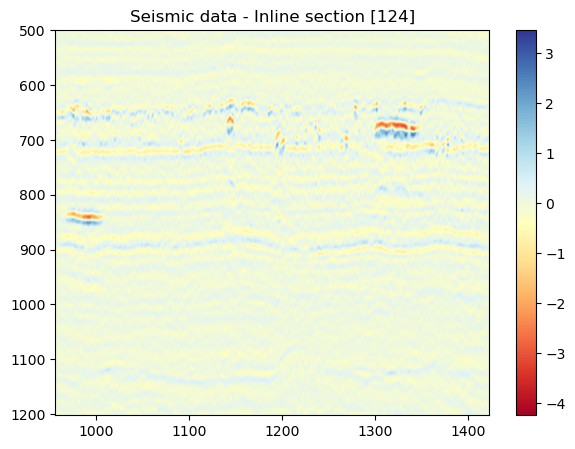

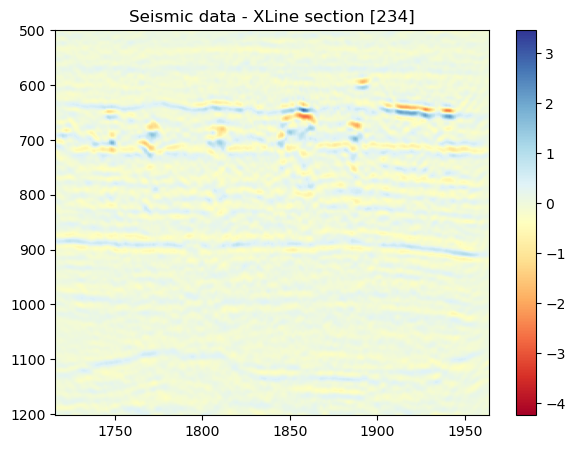

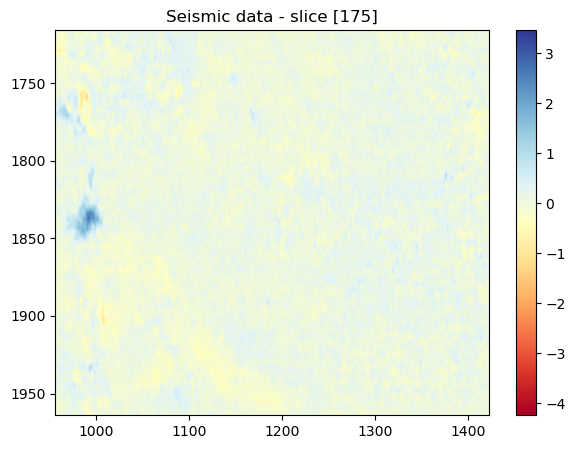

In [64]:
plt.figure(figsize=(7, 5))
plt.imshow(d_small[nil//2].T, cmap='RdYlBu', vmin=traces.min(), vmax=traces.max(),
           extent=(xlines[0], xlines[-1], t[itmax], t[itmin]))
plt.title(f'Seismic data - Inline section [{nil//2}]')
plt.colorbar()
plt.axis('tight');
plt.figure(figsize=(7, 5))
plt.imshow(d_small[:,nxl//2].T, cmap='RdYlBu', vmin=traces.min(), vmax=traces.max(),
           extent=(ilines[0], ilines[-1], t[itmax], t[itmin]))
plt.title(f'Seismic data - XLine section [{nxl//2}]')
plt.colorbar()
plt.axis('tight');
plt.figure(figsize=(7, 5))
plt.imshow(d_small[..., (itmax-itmin)//2], cmap='RdYlBu', vmin=traces.min(), vmax=traces.max(),
           extent=(xlines[0], xlines[-1], ilines[-1], ilines[0]))
plt.title(f'Seismic data - slice [{(itmax-itmin)//2}]')
plt.colorbar()
plt.axis('tight');

## TBT Inversion + Spatial Regularization / Loading

Trace to trace inversion and spatial regularizations were done in separate notebooks

See 03_GPU_Inversion_step1_.ipynb

and 04_GPU_Inversion_step2_Spat_Reg.ipynb

for further info...

In [65]:
# Load the results of inversion from two notebooks:

m_relative = np.load("m_relative.npy").astype(dtype)
r_relative = np.load("r_relative.npy").astype(dtype)
print(f"m_relative shape {m_relative.shape}")

m_relative_reg = np.load("m_relative_reg.npy").astype(dtype)
r_relative_reg = np.load("r_relative_reg.npy").astype(dtype)
print(f"m_relative_reg shape {m_relative_reg.shape}")


m_relative shape (249, 468, 1001)
m_relative_reg shape (1001, 468, 249)


In [66]:
# swap time axis back to last dimension
m_relative_reg = np.swapaxes(m_relative_reg, 0, -1)
print(f"m_relative_reg shape {m_relative_reg.shape}")
r_relative_reg = np.swapaxes(r_relative_reg, 0, -1)

m_relative_reg shape (249, 468, 1001)


#### Displaying the inverted model and residuals

601 250


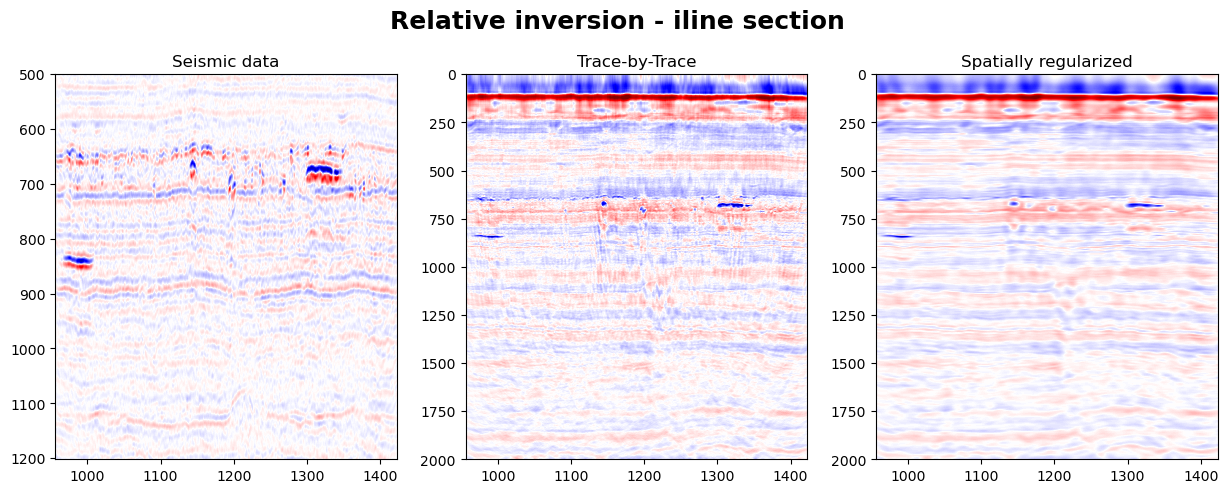

In [67]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
itmax, itmin = int(itmax), int(itmin)
print(itmax, itmin)
fig.suptitle('Relative inversion - iline section', y=1.01, fontweight='bold', fontsize=18)

axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1],t[itmax], t[itmin]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')

axs[1].imshow(m_relative[nil//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1], t[-1], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')

axs[2].imshow(m_relative_reg[nil//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1],t[-1], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

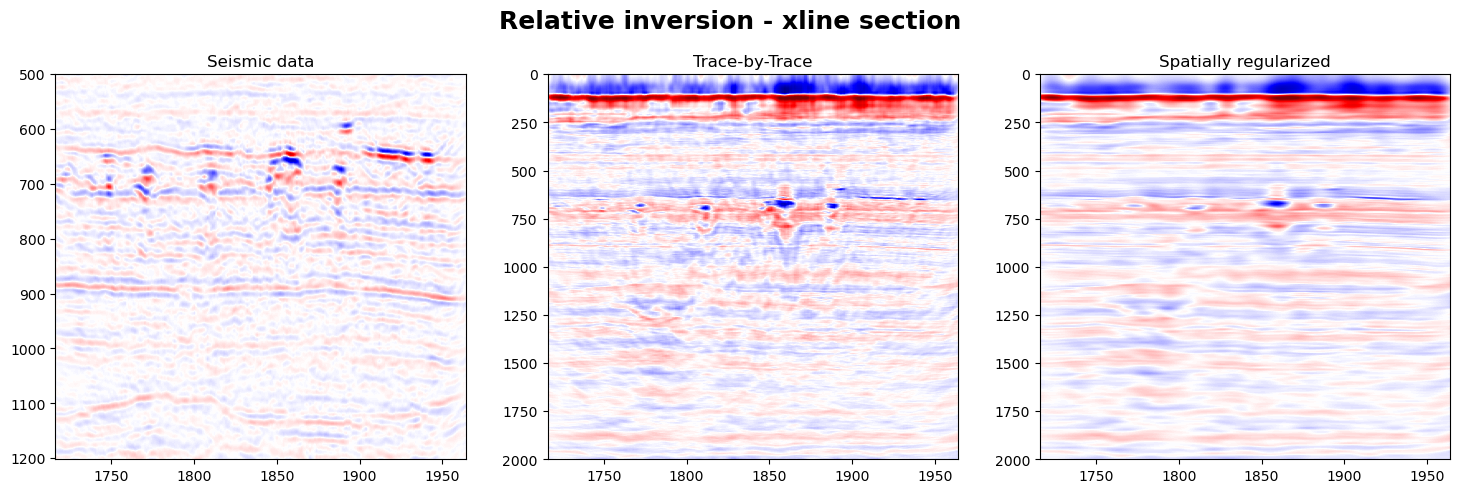

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Relative inversion - xline section', y=1.01, fontweight='bold', fontsize=18)


axs[0].imshow(d_small[:, nxl//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(il[0], il[-1], t[itmax], t[itmin]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')


axs[1].imshow(m_relative[:, nxl//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(il[0], il[-1], t[-1], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')


axs[2].imshow(m_relative_reg[:, nxl//2].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(il[0], il[-1], t[-1], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

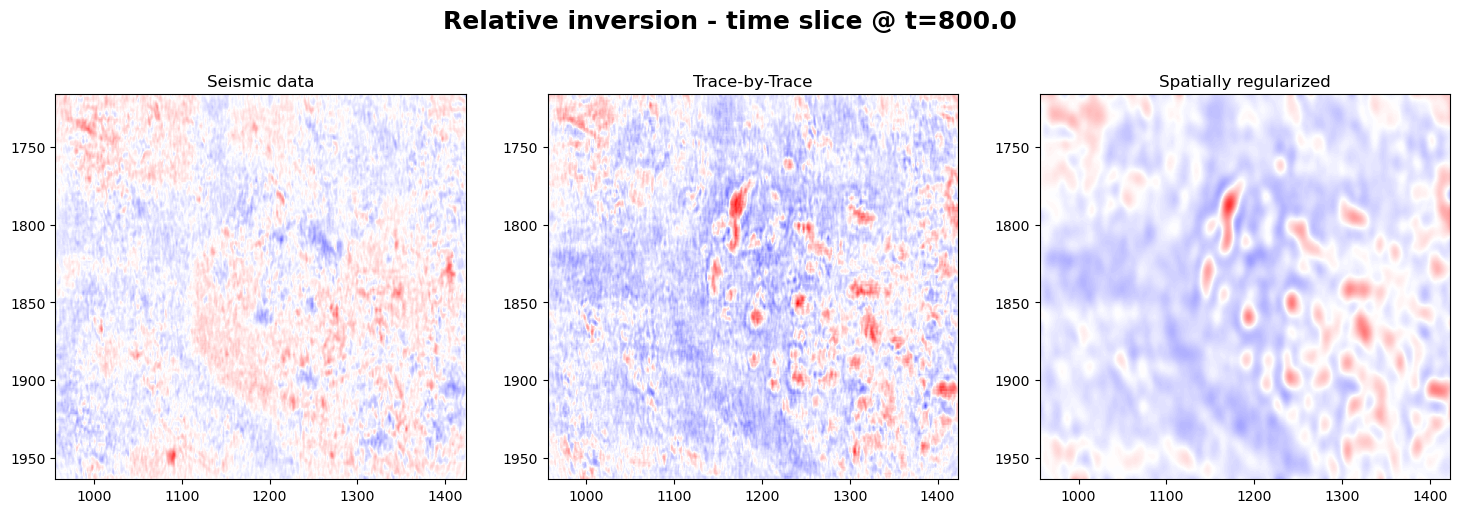

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

t_shift = 150 # Z SAMPLES SHIFT

fig.suptitle('Relative inversion - time slice @ t={}'.format(t[itmin+t_shift]), y=1.05, fontweight='bold', fontsize=18)
axs[0].imshow(d_small[...,t_shift], cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight');
axs[1].imshow(m_relative[...,itmin+t_shift], cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight');
axs[2].imshow(m_relative_reg[...,itmin+t_shift], cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

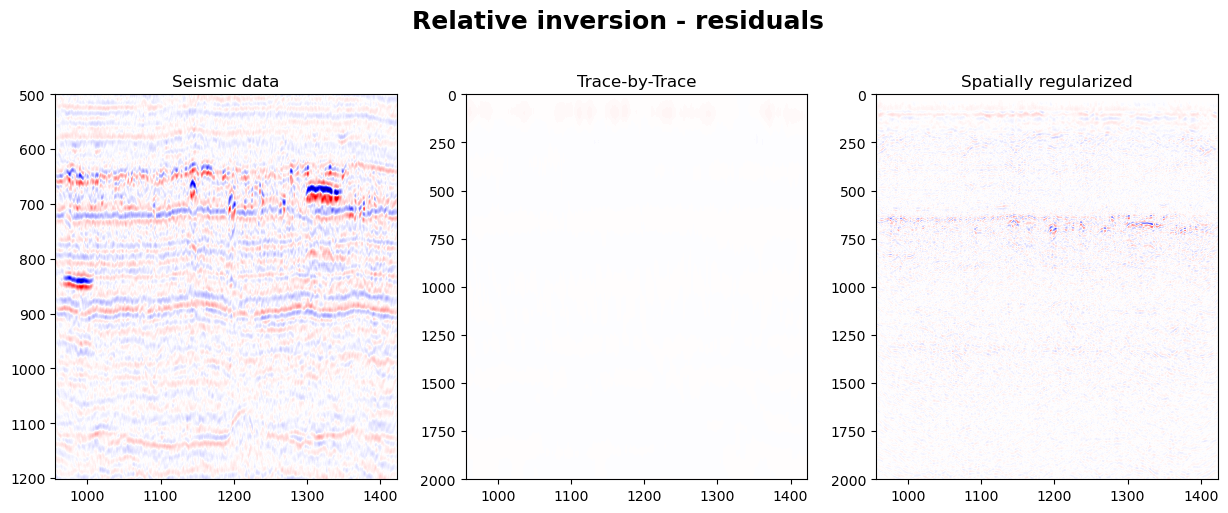

In [70]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Relative inversion - residuals', y=1.05, fontweight='bold', fontsize=18)

axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], t[itmax], t[itmin]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')

axs[1].imshow(r_relative[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], t[-1], t[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')

axs[2].imshow(r_relative_reg[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], t[-1], t[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

## Importing provided Inverted file

In [71]:
inv_file = '''.\SEISMIC\Final_inversion_94p07_IPOPT.segy'''

f_inv = segyio.open(inv_file, ignore_geometry=True)
f_inv.mmap()

False

We thus need to read all ILs, XLs and traces and reorganize them ourselves into a regular grid. No worries, numpy will do most of the hard work

In [72]:
# Geometry fix

t_inv = f_inv.samples
il_inv = f_inv.attributes(segyio.TraceField.INLINE_3D)[:]
xl_inv = f_inv.attributes(segyio.TraceField.CROSSLINE_3D)[:]

traces_inv = segyio.collect(f_inv.trace)[:]
ntraces_inv, nt_inv = traces_inv.shape


################### SAME AS THE ORIGINAL FILE ################
# # define a regular IL and XL axis
# il_unique = np.unique(il)
# xl_unique = np.unique(xl)

# il_min, il_max = min(il_unique), max(il_unique)
# xl_min, xl_max = min(xl_unique), max(xl_unique)

# dt = t[1] - t[0]
# dil = min(np.unique(np.diff(il_unique)))
# dxl = min(np.unique(np.diff(xl_unique)))

# # regular axis
# ilines = np.arange(il_min, il_max + dil, dil)
# xlines = np.arange(xl_min, xl_max + dxl, dxl)
# nil, nxl = ilines.size, xlines.size

# ilgrid, xlgrid = np.meshgrid(np.arange(nil),
#                              np.arange(nxl),
#                              indexing='ij')

# # look-up table
# traces_indeces = np.full((nil, nxl), np.nan)
# iils = (il - il_min) // dil
# ixls = (xl - xl_min) // dxl
# traces_indeces[iils, ixls] = np.arange(ntraces)
# traces_available = np.logical_not(np.isnan(traces_indeces))
# print('# missing traces: {}'.format(np.sum(~traces_available)))

# reorganize traces in regular grid
d_inv = np.zeros((nil, nxl, nt_inv))
d_inv[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces_inv

In [73]:
print(f"traces_inv shape {traces_inv.shape}")
print(f"d_inv shape {d_inv.shape}")

print(t_inv.min(),t_inv.max())

traces_inv shape (116532, 351)
d_inv shape (249, 468, 351)
500.0 1200.0


In [74]:
print(f"traces shape {traces.shape}")
print(f"d shape {d.shape}")
print(f"d_small shape {d_small.shape}")

print(t.min(),t.max())

traces shape (116532, 1001)
d shape (249, 468, 1001)
d_small shape (249, 468, 351)
0.0 2000.0


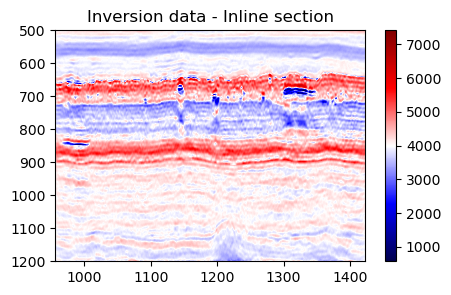

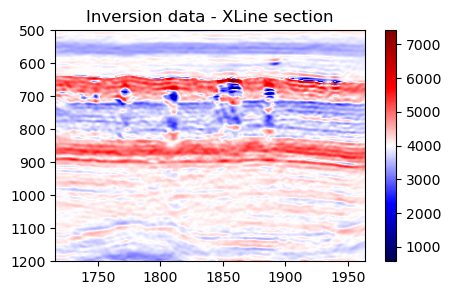

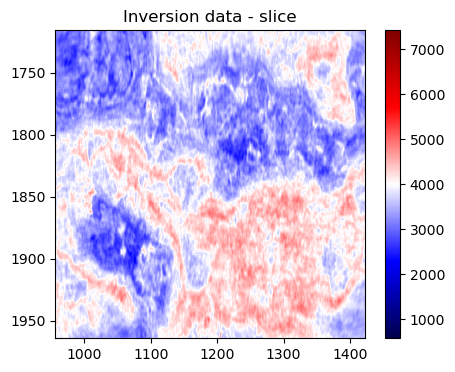

In [75]:
plt.figure(figsize=(5, 3))
plt.imshow(d_inv[nil//2].T, cmap='seismic', vmin=traces_inv.min(), vmax=0.8*traces_inv.max(),
           extent=(xlines[0], xlines[-1], t_inv[-1], t_inv[0]))
plt.title('Inversion data - Inline section')
plt.colorbar()
plt.axis('tight');
plt.figure(figsize=(5, 3))
plt.imshow(d_inv[:,nxl//2].T, cmap='seismic', vmin=traces_inv.min(), vmax=0.8*traces_inv.max(),
           extent=(ilines[0], ilines[-1], t_inv[-1], t_inv[0]))
plt.title('Inversion data - XLine section')
plt.colorbar()
plt.axis('tight');
plt.figure(figsize=(5, 4))
plt.imshow(d_inv[..., (1200-500)//2], cmap='seismic', vmin=traces_inv.min(), vmax=0.8*traces_inv.max(),
           extent=(xlines[0], xlines[-1], ilines[-1], ilines[0]))
plt.title('Inversion data - slice')
plt.colorbar()
plt.axis('tight');

### Animated time slices:

In [76]:
t_inv[0],t_inv[-1]

(500.0, 1200.0)

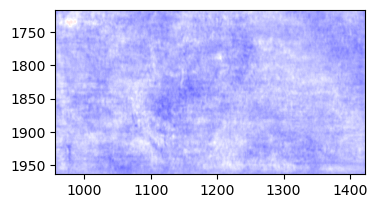

In [77]:
# from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
fig.set_size_inches(4,4)
NTS2 = np.arange(0, (t_inv[-2]-t_inv[0])//2, 5, dtype=int)
def animate_inv(i):
    # ax.clear()
    nt2 = NTS2[i]
    return ax.imshow(d_inv[..., nt2], cmap='seismic', vmin=traces_inv.min(), vmax=traces_inv.max(),
           extent=(xlines[0], xlines[-1], ilines[-1], ilines[0]))
ani_inv = FuncAnimation(fig, animate_inv, frames=len(NTS2)-1,interval=100, repeat=False)

In [78]:
from IPython.display import HTML
HTML(ani_inv.to_html5_video())

### Compare provided inversion with ours:

In [79]:
d_inv.min(),d_inv.max()

(571.111083984375, 9276.0546875)

In [80]:
m_relative.min(),m_relative.max()

(-3.9945674, 4.8640385)

#### Inline:

601 250


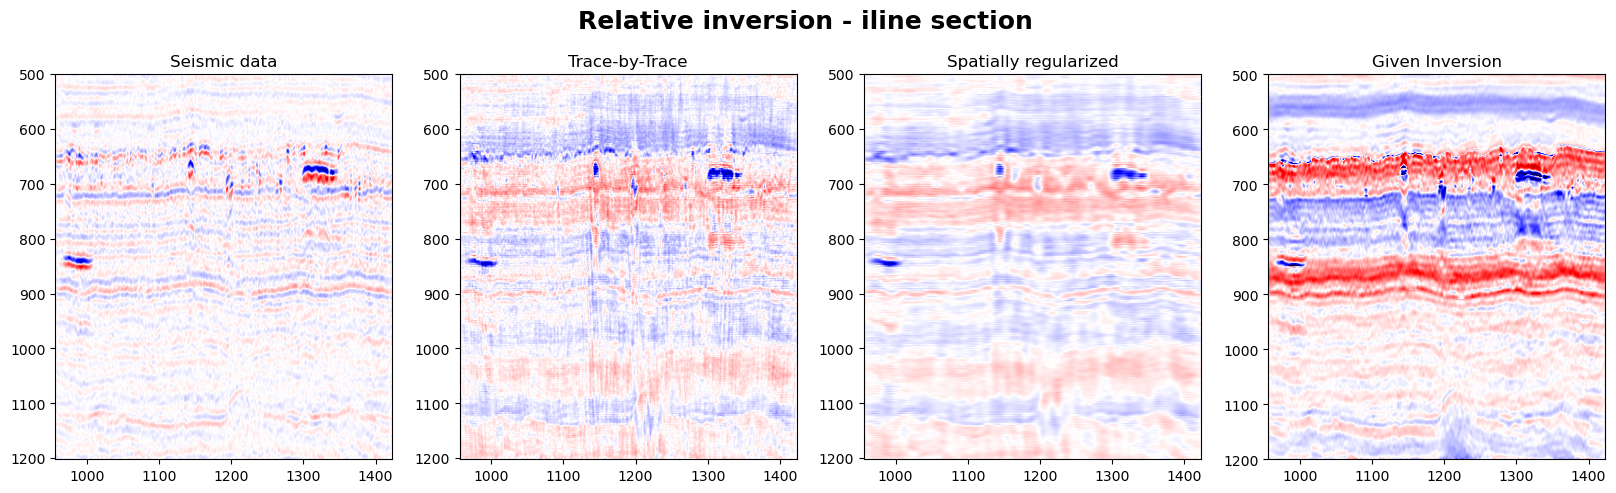

In [81]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
itmax, itmin = int(itmax), int(itmin)
print(itmax, itmin)
fig.suptitle('Relative inversion - iline section', y=1.01, fontweight='bold', fontsize=18)

axs[0].imshow(d_small[nil//2].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1],t[itmax], t[itmin]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')

axs[1].imshow(m_relative[nil//2,:,itmin:itmax].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1], t[itmax], t[itmin]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')

axs[2].imshow(m_relative_reg[nil//2,:,itmin:itmax].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1],t[itmax], t[itmin]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

axs[3].imshow(d_inv[nil//2].T, cmap='seismic', vmin=d_inv.min(), vmax=0.8*d_inv.max(),
              extent=(xl[0], xl[-1],t_inv[-1], t_inv[0]))
axs[3].set_title('Given Inversion')
axs[3].axis('tight');

#### Xline:

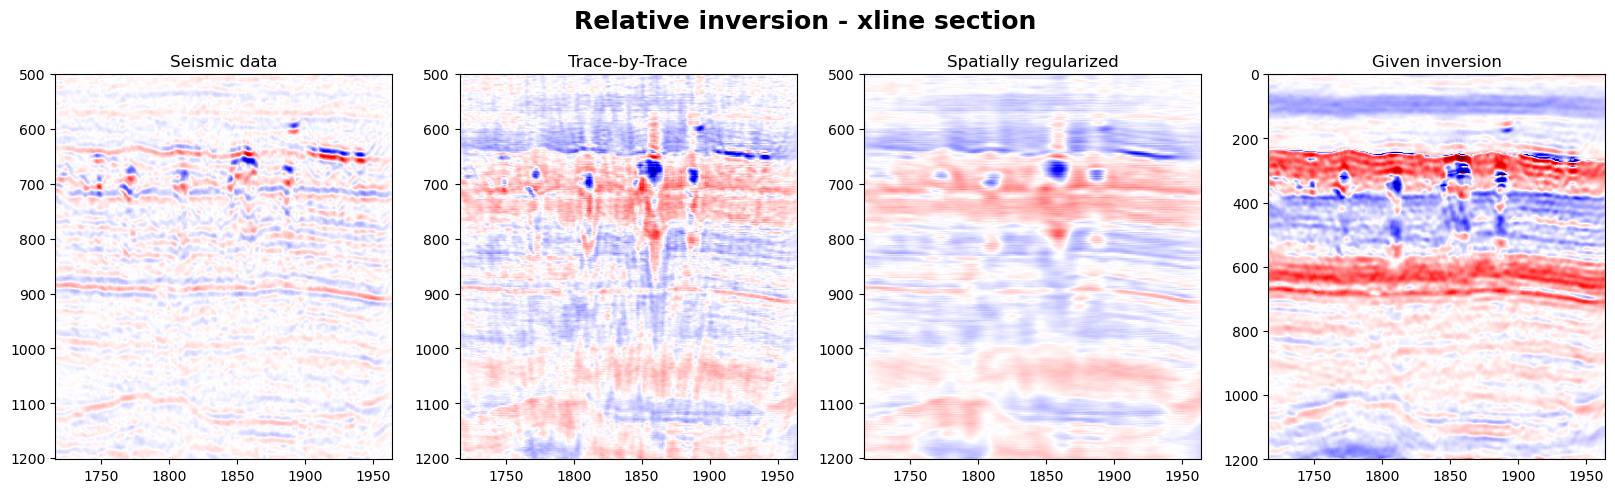

In [82]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Relative inversion - xline section', y=1.01, fontweight='bold', fontsize=18)


axs[0].imshow(d_small[:, nxl//2,:].T, cmap='seismic', vmin=-4, vmax=4,
              extent=(il[0], il[-1], t[itmax], t[itmin]))
axs[0].set_title('Seismic data')
axs[0].axis('tight')


axs[1].imshow(m_relative[:, nxl//2,itmin:itmax].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(il[0], il[-1], t[itmax], t[itmin]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight')


axs[2].imshow(m_relative_reg[:, nxl//2,itmin:itmax].T, cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(il[0], il[-1], t[itmax], t[itmin]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');

axs[3].imshow(d_inv[:, nxl//2].T, cmap='seismic', vmin=d_inv.min(), vmax=0.8*d_inv.max(),
              extent=(il[0], il[-1], t_inv[-1], t[0]))
axs[3].set_title('Given inversion')
axs[3].axis('tight');

#### Time-section

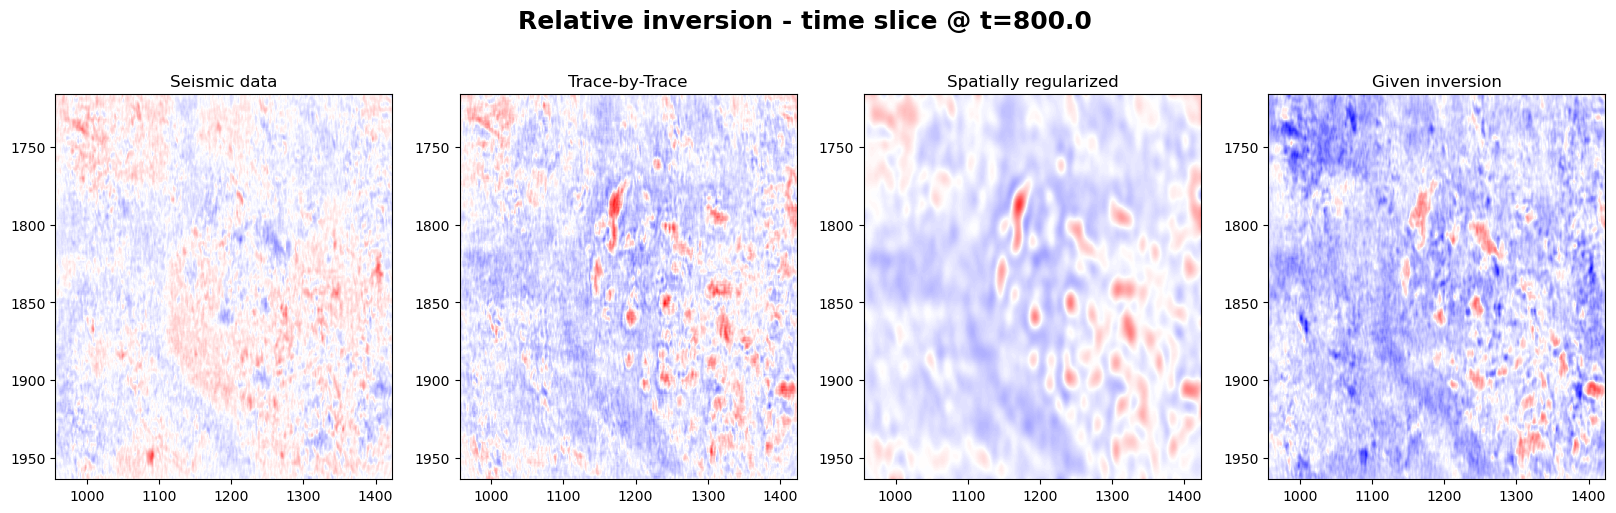

In [83]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

t_shift = 150 # Z SAMPLES SHIFT

fig.suptitle('Relative inversion - time slice @ t={}'.format(t[itmin+t_shift]), y=1.05, fontweight='bold', fontsize=18)
axs[0].imshow(d_small[...,t_shift], cmap='seismic', vmin=-4, vmax=4,
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[0].set_title('Seismic data')
axs[0].axis('tight');
axs[1].imshow(m_relative[...,itmin+t_shift], cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[1].set_title('Trace-by-Trace')
axs[1].axis('tight');
axs[2].imshow(m_relative_reg[...,itmin+t_shift], cmap='seismic', vmin=-0.7*m_relative.max(), vmax=0.7*m_relative.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[2].set_title('Spatially regularized')
axs[2].axis('tight');
axs[3].imshow(d_inv[...,t_shift], cmap='seismic', vmin=d_inv.min(), vmax=0.8*d_inv.max(),
              extent=(xl[0], xl[-1], il[-1], il[0]))
axs[3].set_title('Given inversion')
axs[3].axis('tight');

# MODEL:

In [84]:
len(d_small[0,0])

351

In [85]:
len(d_inv[0,0])

351

In [86]:
def waveplot(t,y, zero = 0):
    plt.figure(figsize=(30,2))
    plt.plot( t, y, lw=2, color='black', alpha=0.5)
    # plt.fill_between(t, y, 0,  y > 0.0, interpolate=True, hold=True, color='blue', alpha = 0.5)
    # plt.fill_between(t, y, 0, y < 0.0, interpolate=True, hold=True, color='red', alpha = 0.5)
    plt.fill_between(t, y, zero,
                 where = (y < zero),
                 color = 'red', alpha = 0.5)
    plt.fill_between(t, y, zero,
                 where = (y > zero),
                 color = 'blue', alpha = 0.5)
    plt.xlabel( 'two-way time (s)', fontsize = 14)
    plt.ylabel('amplitude', fontsize = 14)
    plt.xlim((min(t),max(t)))
    plt.ylim((min(y),max(y)))
    plt.grid()
    plt.show()


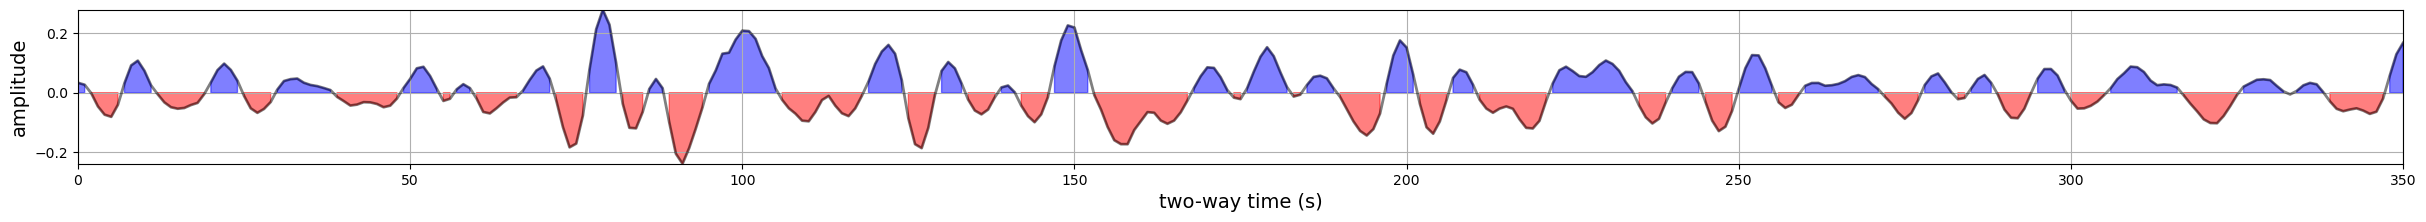

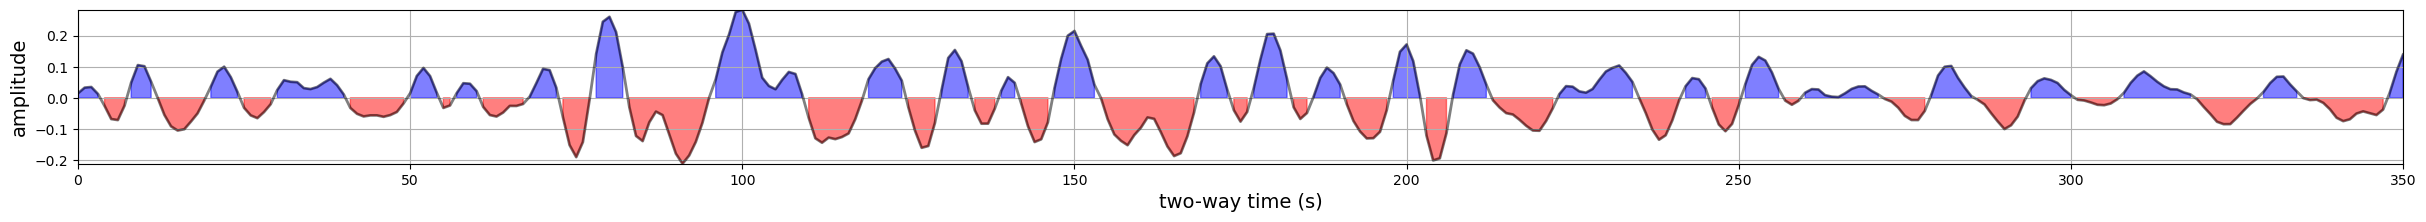

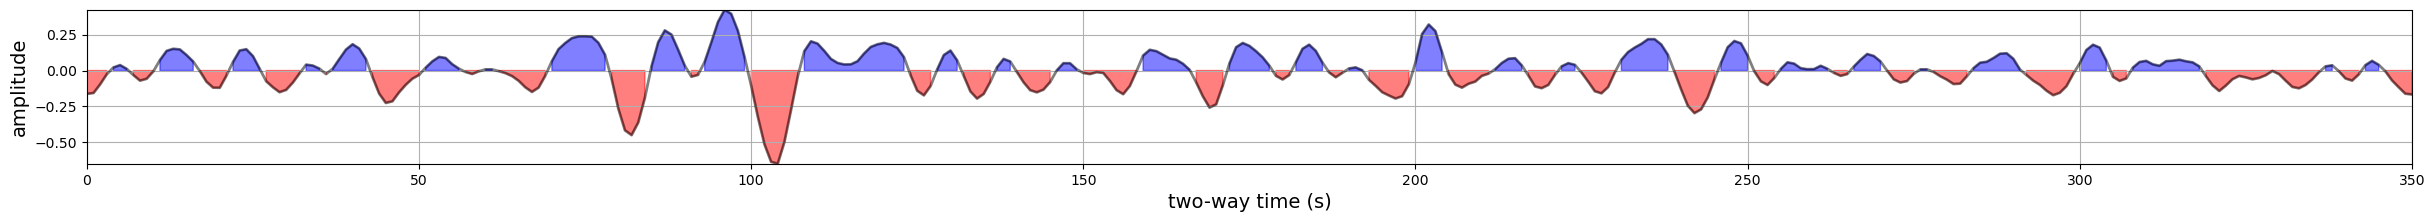

In [87]:
waveplot(range(len(d_small[0,1])),d_small[0,0])
waveplot(range(len(d_small[0,1])),d_small[0,1])
waveplot(range(len(d_small[0,1])),d_small[0,50])

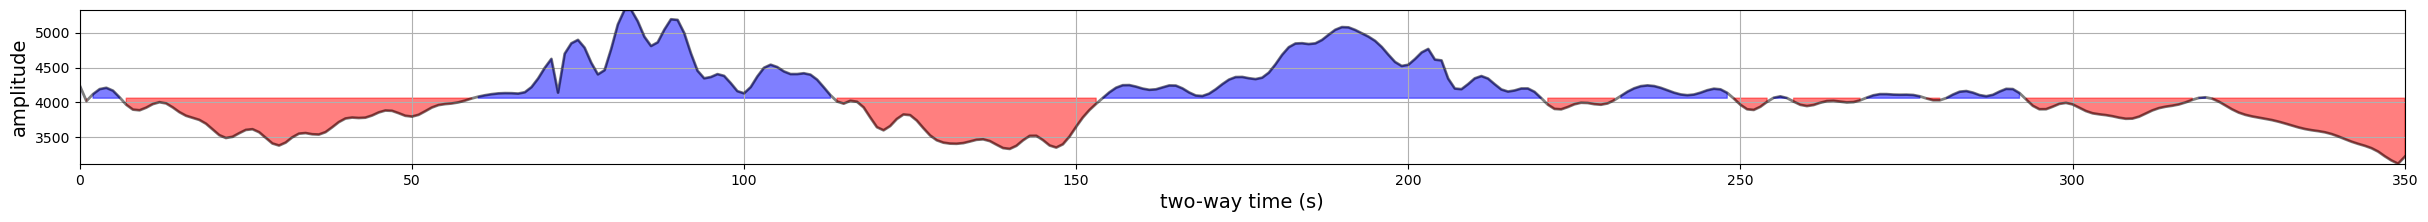

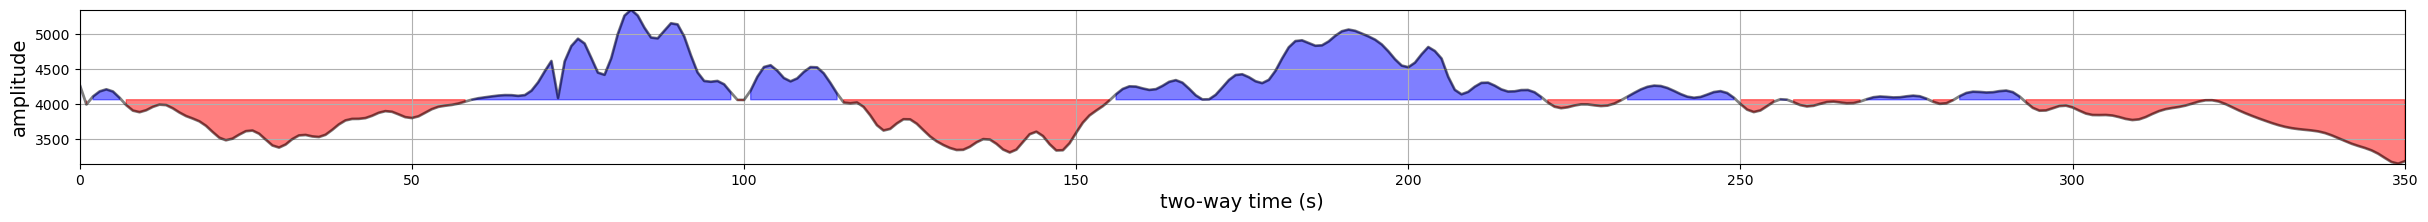

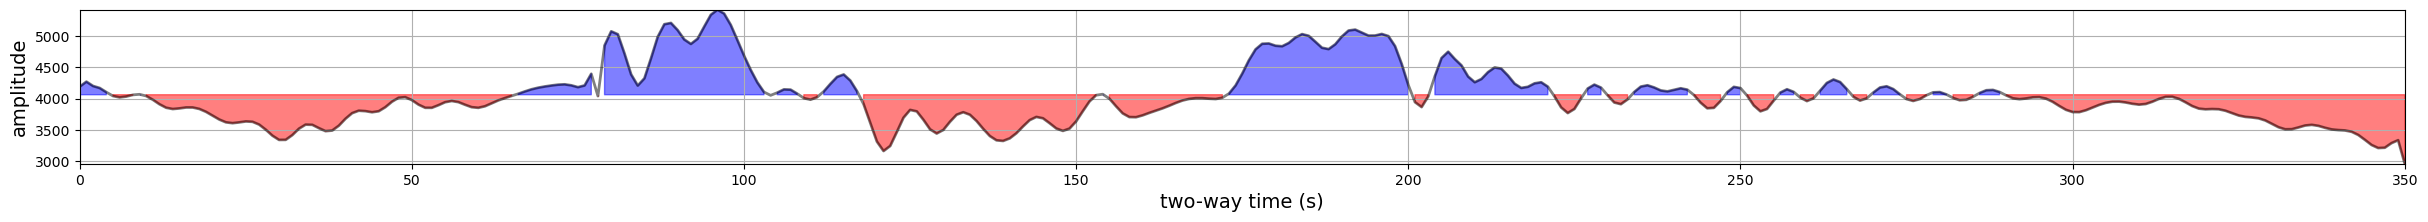

In [88]:
waveplot(range(len(d_inv[0,0])),d_inv[0,0], zero = d_inv[0,0].mean())
waveplot(range(len(d_inv[0,0])),d_inv[0,1], zero = d_inv[0,0].mean())
waveplot(range(len(d_inv[0,0])),d_inv[0,100], zero = d_inv[0,0].mean())


In [89]:
# We will move to separate Notebook to utilize gpu

# Let's export our data:

np.save("d_small",d_small)
np.save("d_inv",d_inv)


# EXTRAS:

### Write inverted cube back to a segy

Not regularized:

In [90]:
# Bring traces back to their original order and backuping
# traces_to_save =  m_relative_cpu[ilgrid.ravel()[traces_available.ravel()],
#                                  xlgrid.ravel()[traces_available.ravel()]]

# np.save("backup_tts.npy", traces_to_save)

In [91]:
# segyfile_inverted = './inverted.segy'

# with segyio.open(inv_file, ignore_geometry=True) as source:
#         spec = segyio.spec()
#         spec.format = int(source.format)
#         spec.samples = t[itmin:itmax]
#         spec.tracecount = source.tracecount
#         print("spec done...")
#         with segyio.open(segyfile_inverted, "r+") as destination:
#             # Code below is commented as I use copied file of original data for destination
#             # Copy all textual headers, including possible extended
#             # for i in range(source.ext_headers):
#             #     destination.text[i] = source.text[i]

#             # # Copy the binary header, then insert the modifications needed for the new time axis
#             # destination.bin = source.bin
#             # destination.bin = {segyio.BinField.Samples: itmax-itmin}
            
#             # # Copy all trace headers to destination file
#             # destination.header = source.header 

#             # Copy data and modify trace header
#             from tqdm.notebook import tqdm
#             for itrace in tqdm(range(destination.tracecount)):
#                 destination.header[itrace] = {segyio.TraceField.TRACE_SAMPLE_COUNT: itmax-itmin} 
#                 destination.trace[itrace] = traces_to_save[itrace].astype('float32')

In [92]:
# Bring traces back to their original order and backuping

# traces_to_save_reg =  m_relative_reg[ilgrid.ravel()[traces_available.ravel()],
#                                  xlgrid.ravel()[traces_available.ravel()]]

# np.save("backup_tts_reg.npy", traces_to_save_reg)

Saving Regularized inversion traces:

In [93]:
# segyfile_inverted_reg = './inverted_reg.segy'
# with segyio.open(inv_file, ignore_geometry=True) as source:
#         spec = segyio.spec()
#         spec.format = int(source.format)
#         spec.samples = t[itmin:itmax]
#         spec.tracecount = source.tracecount
#         print("spec done...")
#         with segyio.open(segyfile_inverted_reg, "r+") as destination:
#             # Code below is commented as I use copied file of original data for destination
#             # Copy all textual headers, including possible extended
#             # for i in range(source.ext_headers):
#             #     destination.text[i] = source.text[i]

#             # # Copy the binary header, then insert the modifications needed for the new time axis
#             # destination.bin = source.bin
#             # destination.bin = {segyio.BinField.Samples: itmax-itmin}
            
#             # # Copy all trace headers to destination file
#             # destination.header = source.header 

#             # Copy data and modify trace header
#             from tqdm.notebook import tqdm
#             for itrace in tqdm(range(destination.tracecount)):
#                 destination.header[itrace] = {segyio.TraceField.TRACE_SAMPLE_COUNT: itmax-itmin} 
#                 destination.trace[itrace] = traces_to_save_reg[itrace].astype('float32')

Read the file back to check if saving was successful

In [94]:
# f1 = segyio.open(segyfile_inverted, ignore_geometry=True)
# traces1 = segyio.collect(f1.trace)[:]

# np.allclose(traces1, traces_to_save)
# #Return True if writing was successful